1) Load data from "Live_20210128.csv" file. Remove unwanted features if required.

In [16]:
import numpy as np
import pandas
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import seaborn


reactions = pandas.read_csv("Live_20210128.csv")
reactions.drop(columns=["Column1","Column2","Column3","Column4","status_id","status_published"] , inplace = True)

## The status type might be important. We will utilize the conversion from text to number, considering  video = 1 and photo = 0
reactions['status_type'] = LabelEncoder().fit_transform(reactions['status_type'])
reactions.status_type
reactions.drop(columns=['status_type'], axis=1)
y_true = reactions['status_type'];

In [17]:
main_colums = ['num_reactions', 'num_comments', 'num_shares', 'num_likes', 'num_loves', 'num_wows', 'num_hahas', 'num_sads', 'num_angrys']
reactions_scaled = pandas.DataFrame(MinMaxScaler().fit_transform(reactions[main_colums]), columns = reactions[main_colums].columns)
reactions.drop( main_colums, inplace = True, axis = 1)
reactions = pandas.concat([reactions,reactions_scaled], axis = 1)
reactions.head()

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,3,0.112314,0.024393,0.076519,0.091720,0.140030,0.010791,0.006369,0.019608,0.0
1,1,0.031847,0.000000,0.000000,0.031847,0.000000,0.000000,0.000000,0.000000,0.0
2,3,0.048195,0.011243,0.016647,0.043312,0.031963,0.003597,0.006369,0.000000,0.0
3,1,0.023567,0.000000,0.000000,0.023567,0.000000,0.000000,0.000000,0.000000,0.0
4,1,0.045223,0.000000,0.000000,0.043312,0.013699,0.000000,0.000000,0.000000,0.0


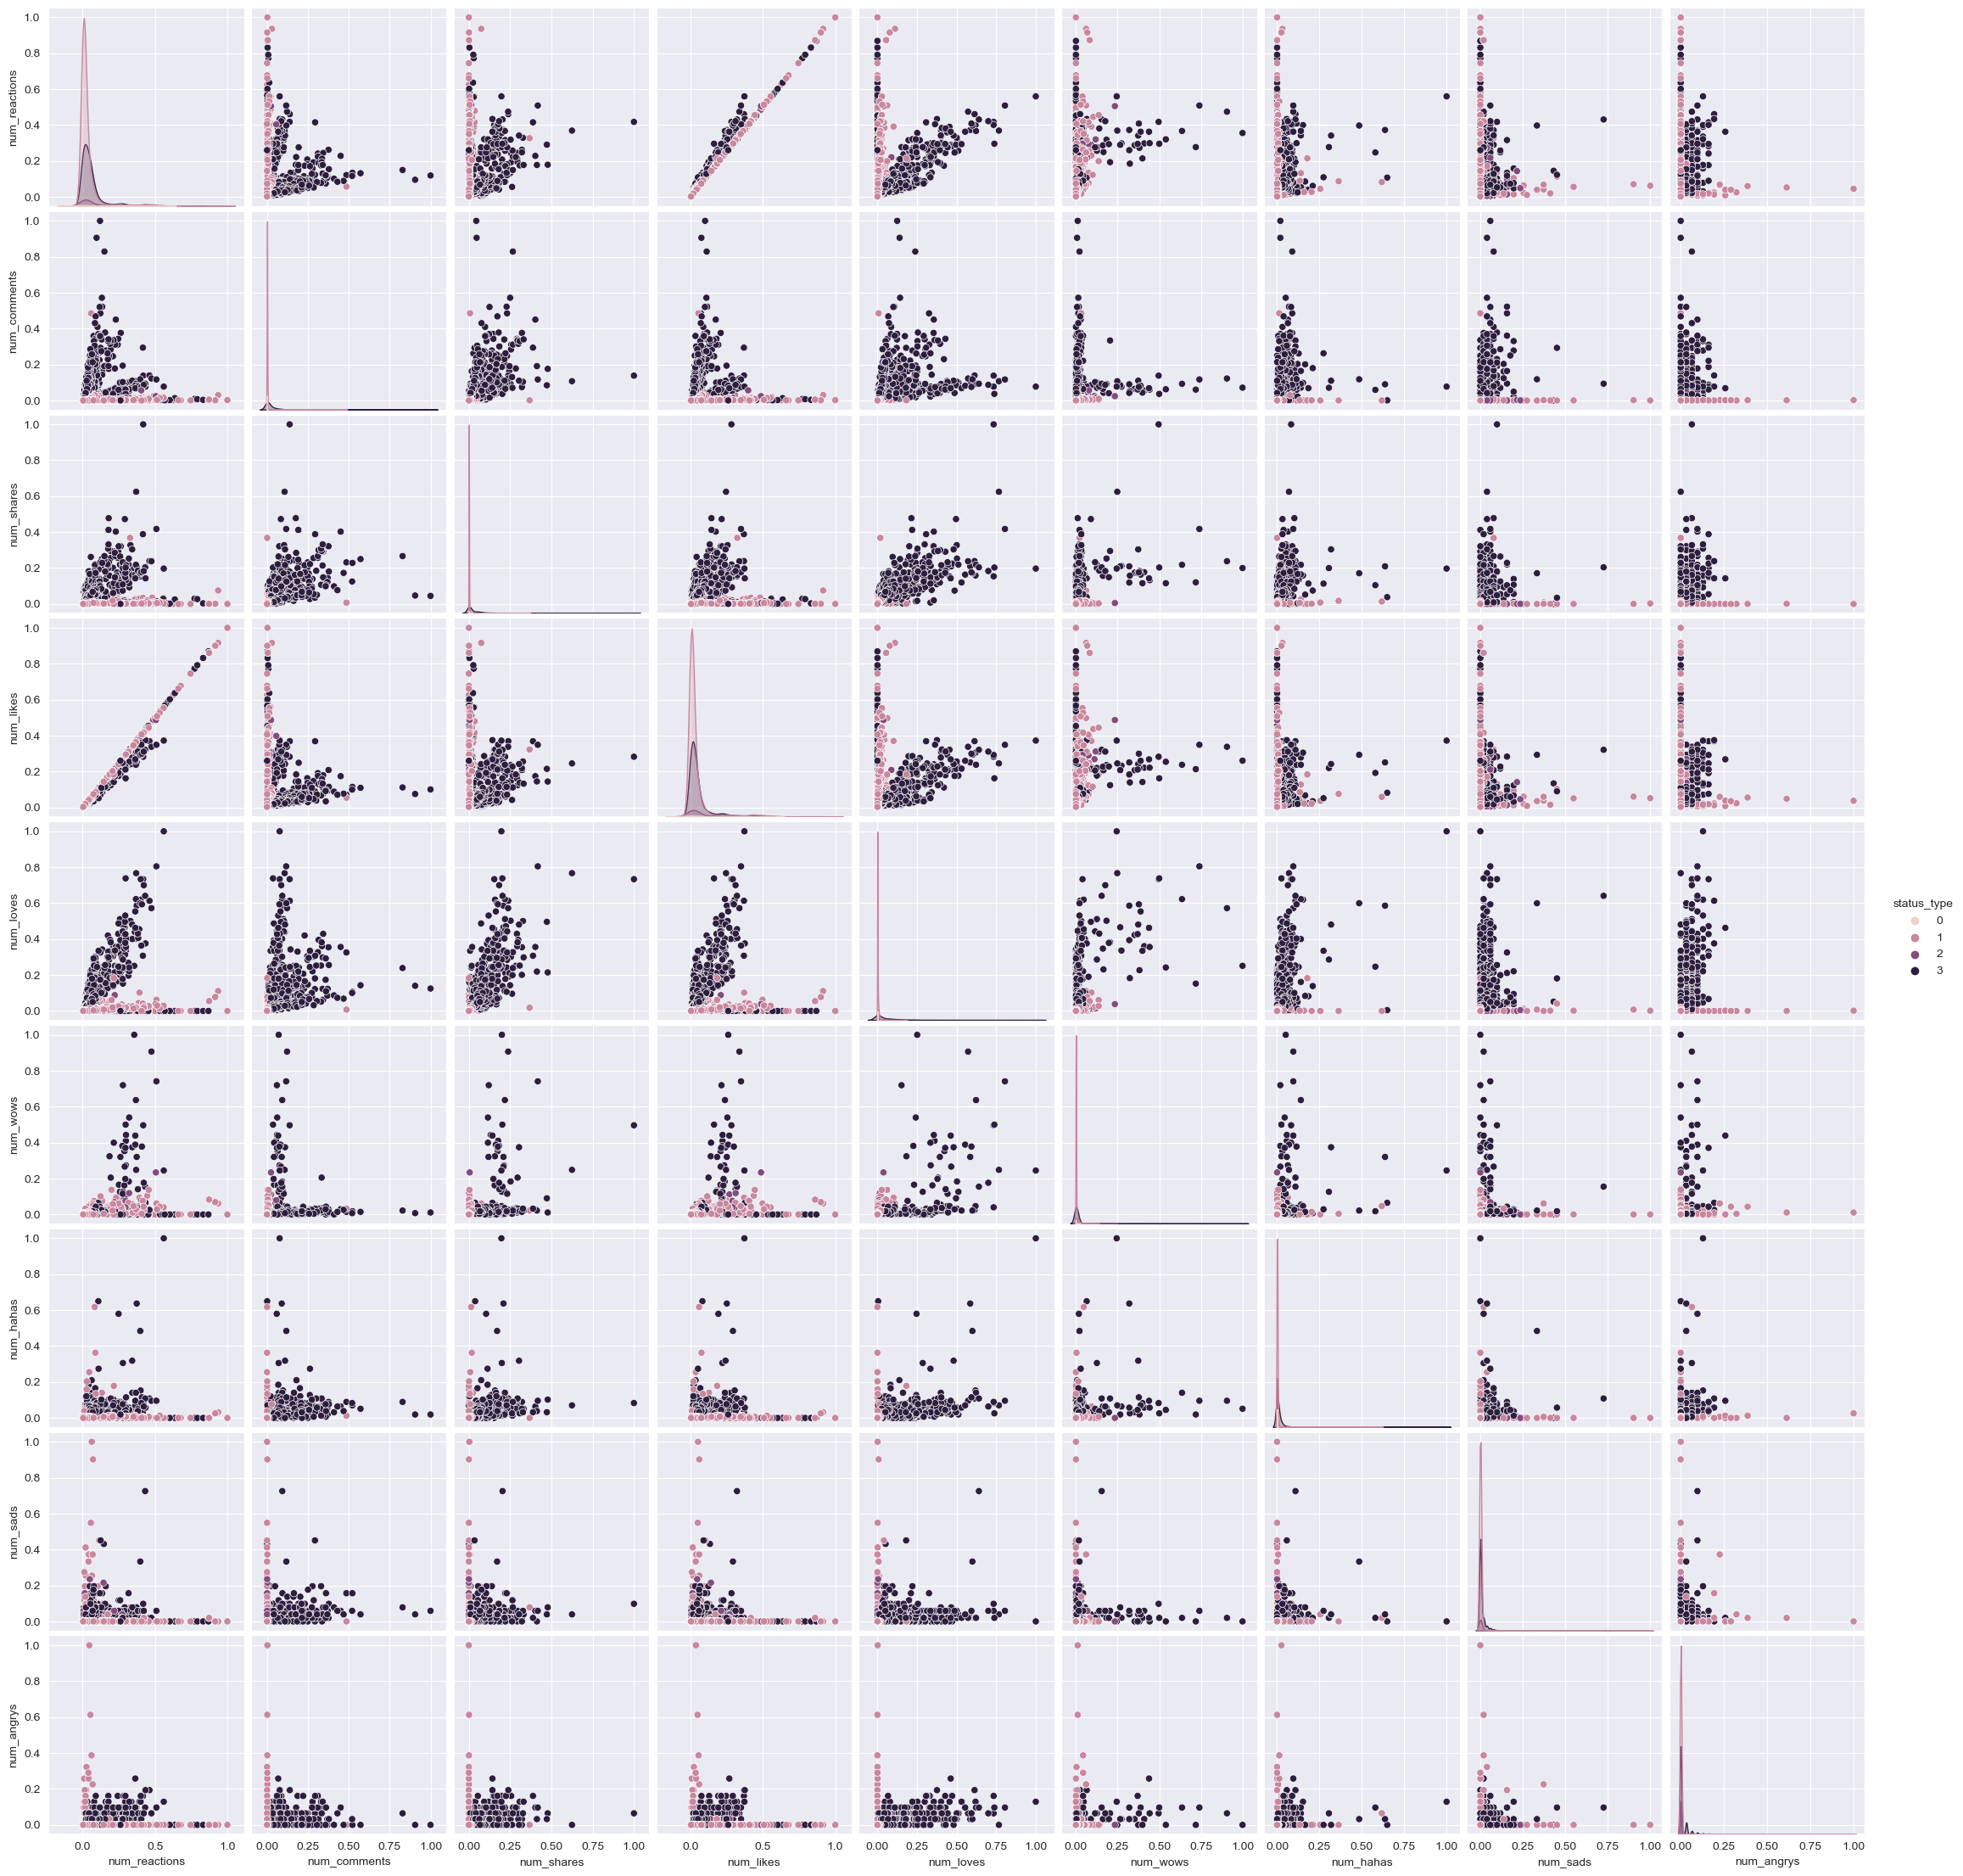

In [18]:
seaborn.pairplot(reactions, hue = 'status_type')

2) Select the optimum k value using Silhouette Coefficient and plot the optimum k values.

best silhouette value=0.8772595629817376 found on k=4


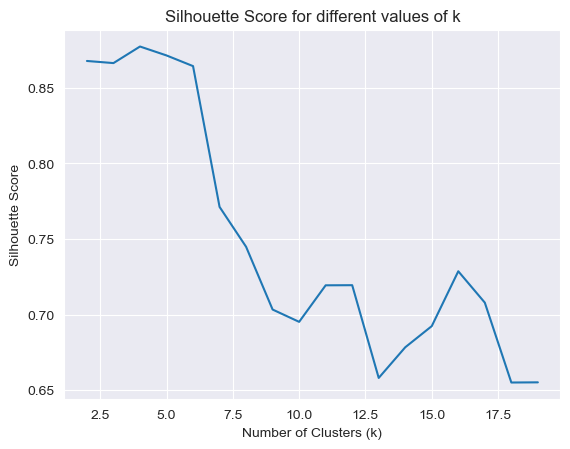

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.pyplot as plt


range_n_clusters = list(range(2,20)) 

# List to hold the silhouette score for each k
sil_scores = []

optimum = {
'max_silhuette' : 0,
'kmeans': None,
'n_clusters' : 0 }



for n_clusters in range_n_clusters:
   cluster = KMeans(n_clusters=n_clusters, n_init='auto').fit(reactions)
   label = cluster.labels_
   sil_score = silhouette_score(reactions,label, metric= 'euclidean') 
   sil_scores.append(sil_score)
   if sil_score > optimum['max_silhuette']:
       optimum['max_silhuette'] = sil_score
       optimum['kmeans'] = cluster
       optimum['n_clusters'] = n_clusters

print(f"best silhouette value={optimum['max_silhuette']} found on k={optimum['n_clusters']}")
# Plot Silhouette Score 
plt.plot(range_n_clusters, sil_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different values of k')
plt.show()



In [25]:
from sklearn.metrics import classification_report
from sklearn import metrics
import numpy
##input k
y = reactions['status_type']
x = reactions
k = optimum['n_clusters']

def purity_score(y_true1, y_pred1):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true1, y_pred1)
    # return purity
    return numpy.sum(numpy.amax(contingency_matrix, axis=0)) / numpy.sum(contingency_matrix) 
    
    
model = KMeans(n_clusters=k, n_init=10)
y_pred = model.fit_predict(x)
y_pred_df = pandas.DataFrame(y_pred, columns=["status_type"])
print(classification_report(y, y_pred_df))
print(
"purity_score: %0.3f"
    % purity_score(y_true, y_pred)
)

y_pred_plus = KMeans(n_clusters=k, init='k-means++', n_init=100).fit_predict(x)
print(classification_report(y, y_pred_plus))
print(
"purity_score: %0.3f"
    % purity_score(y_true, y_pred_plus)
)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        63
           1       0.99      0.95      0.97      4288
           2       1.00      1.00      1.00       365
           3       0.00      0.00      0.00      2334

    accuracy                           0.63      7050
   macro avg       0.50      0.49      0.49      7050
weighted avg       0.65      0.63      0.64      7050

purity_score: 0.991
              precision    recall  f1-score   support

           0       0.01      0.78      0.02        63
           1       0.00      0.00      0.00      4288
           2       1.00      1.00      1.00       365
           3       0.00      0.00      0.00      2334

    accuracy                           0.06      7050
   macro avg       0.25      0.44      0.26      7050
weighted avg       0.05      0.06      0.05      7050

purity_score: 0.991


4) Now repeat clustering using Kmeans for 50 times and report the average performance. Again compare the results that you have obtained in Q3 using Kmeans++ and explain the difference (if any).

In [41]:
scores=0.0;
for _ in range(50):
    kmeans = KMeans(n_clusters=4, init='random', max_iter=300, n_init=1, random_state=None)
    kmeans.fit(x)
    score = kmeans.inertia_  # This is the within-cluster sum of squares for the current run
    value =  purity_score(y_true,kmeans.fit_predict(x))
    #print (value)
    scores = scores + value
    
print (scores)
print("Average purity score over 50 runs:", scores/50)



49.54609929078016
Average purity score over 50 runs: 0.9909219858156032


The purity did not change much. the individual values of the purity did change quite significantly through the iterations, with some of the random initialization getting to 1.

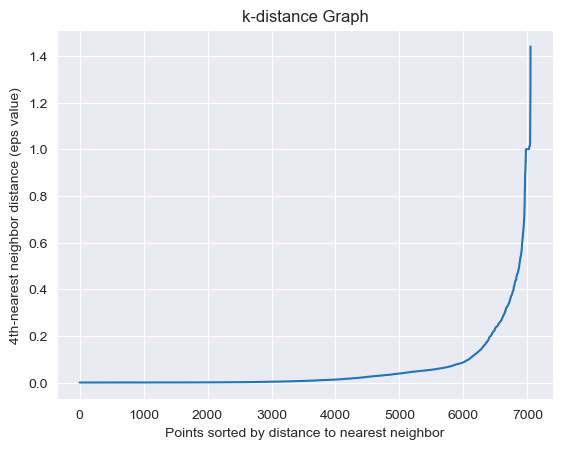

Number of clusters: 3


In [87]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
# Start by calculating the distance to the nearest n_neighbors for each point
nearest_neighbors = NearestNeighbors(n_neighbors=200 )# MinPts parameter, can be adjusted
nearest_neighbors.fit(reactions)
distances, indices = nearest_neighbors.kneighbors(reactions)

# Sort the distances
distances = numpy.sort(distances[:, -1])

# Plot the k-distance graph
plt.plot(distances)
plt.xlabel('Points sorted by distance to nearest neighbor')
plt.ylabel('4th-nearest neighbor distance (eps value)')
plt.title('k-distance Graph')
plt.show()


# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=200)
clusters = dbscan.fit_predict(reactions)

# Check the number of clusters found
n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
print(f'Number of clusters: {n_clusters}')


Analising the knee point for the curve on k-distance chart, we get an epsilon of  0.2 for a 200 number of neighbours. this was used as the optimised parameters for our dbscan execution. 

The two algorithms work very differently. while k-means trie to assign every point to a cluster and bases the clusters on the mean value of the points,  DBSCAN bases them on the density of the points and can leave points unassigned (as noise) if they're not in a dense area. 
While kmeans gave us 4 clusters as the result of the silhouette coefficient comparison, while DBSCAN gave us 3.